This will be the main notebook, where data is loaded, investigated, prepared, and models are build, trained and experimented with.

## Data Loading

In [1]:
import os
import cv2
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
PATH_IMAGES = os.path.join('Kvasir-SEG', 'images')
PATH_LABELS = os.path.join('Kvasir-SEG', 'bbox')
PATH_ANNOTATED_IMAGES = os.path.join('Kvasir-SEG', 'annotated_images')

In [3]:
def load_images(directory_path):
    """ Returns a list of file paths to all .jpg images in the given directory. """
    image_files = []
    for filename in os.listdir(directory_path):
        if filename.lower().endswith('.jpg'):
            file_path = os.path.join(directory_path, filename)
            image_files.append(file_path)
    return sorted(image_files)

image_paths = load_images(PATH_IMAGES)
len(image_paths)

1000

In [4]:
def load_labels(label_dir):
    """ 
    Loads all CSV label files from the specified directory. 
    Open each file, and save corners of each bounding box together with id/filename as new row.
    Combine everything into a single DataFrame and return it.
    """
    all_labels = []

    for filename in sorted(os.listdir(label_dir)):
        if filename.endswith(".csv"):
            file_id = os.path.splitext(filename)[0]
            df = pd.read_csv(os.path.join(label_dir, filename))
            df["id"] = file_id
            all_labels.append(df)

    labels_df = pd.concat(all_labels, ignore_index=True)

    return labels_df

labels_df = load_labels(PATH_LABELS)
labels_df.shape

(1071, 6)

We define the logic for loading an image with its belonging bounding boxes by implementing a torch dataset.

We implement two return formats, one suited for the use with a YOLO model, and a second for the use with a Faster RCNN model.

In [5]:
class KvasirPolypDataset(Dataset):
    """
    Dataset for Kvasir-SEG supporting:
      - YOLO format
      - Faster R-CNN format

    format="yolo":
        returns:
            image: Tensor (3, H, W)
            targets: Tensor (N, 5) [class, x_c, y_c, w, h] normalized
            img_id: str

    format="fasterrcnn":
        returns:
            id: str
            image: Tensor (3, H, W)
            target: dict {
                "boxes":  FloatTensor (N, 4) [xmin, ymin, xmax, ymax] (pixels)
                "labels": Int64Tensor (N,)
            }
    """

    def __init__(
        self,
        images_dir,
        labels_df,
        img_size=None,
        default_class=0,
        transforms=None,
        format="yolo",          # "yolo" or "fasterrcnn"
    ):
        super().__init__()

        assert format in ["yolo", "fasterrcnn"]
        self.format = format

        self.images_dir = images_dir
        self.img_paths = load_images(images_dir)
        self.img_size = img_size
        self.default_class = default_class
        self.transforms = transforms

        # id -> dataframe with boxes
        self.id_to_boxes = {
            img_id: group.reset_index(drop=True)
            for img_id, group in labels_df.groupby("id")
        }

        image_ids = {os.path.splitext(os.path.basename(p))[0] for p in self.img_paths}
        labeled_ids = set(self.id_to_boxes.keys())

        print(f"Total images: {len(image_ids)}")
        print(f"Images with at least one bbox: {len(labeled_ids)}")
        print(f"Images without bbox: {len(image_ids - labeled_ids)}")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img_id = os.path.splitext(os.path.basename(img_path))[0]

        # ---- load image ----
        img = cv2.imread(img_path)
        if img is None:
            raise RuntimeError(f"Cannot read image: {img_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = img.shape[:2]

        # ---- resize if needed ----
        if self.img_size is not None:
            img = cv2.resize(img, (self.img_size, self.img_size))
            new_h, new_w = self.img_size, self.img_size
            scale_x = new_w / orig_w
            scale_y = new_h / orig_h
        else:
            new_h, new_w = orig_h, orig_w
            scale_x = scale_y = 1.0

        # ---- to tensor ----
        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))
        img_tensor = torch.from_numpy(img)

        df_boxes = self.id_to_boxes.get(img_id, None)

        # YOLO FORMAT
        # ------------
        if self.format == "yolo":
            targets = []

            if df_boxes is not None:
                for _, row in df_boxes.iterrows():
                    xmin = row["xmin"] * scale_x
                    ymin = row["ymin"] * scale_y
                    xmax = row["xmax"] * scale_x
                    ymax = row["ymax"] * scale_y

                    box_w = xmax - xmin
                    box_h = ymax - ymin
                    if box_w <= 0 or box_h <= 0:
                        continue

                    x_c = (xmin + box_w / 2) / new_w
                    y_c = (ymin + box_h / 2) / new_h
                    box_w /= new_w
                    box_h /= new_h

                    targets.append([
                        float(self.default_class),
                        x_c, y_c, box_w, box_h
                    ])

            if len(targets) > 0:
                targets = torch.tensor(targets, dtype=torch.float32)
            else:
                targets = torch.zeros((0, 5), dtype=torch.float32)

            return img_tensor, targets, img_id

        # FASTER R-CNN FORMAT
        # --------------------
        else:
            boxes = []
            labels = []

            if df_boxes is not None:
                for _, row in df_boxes.iterrows():
                    xmin = row["xmin"] * scale_x
                    ymin = row["ymin"] * scale_y
                    xmax = row["xmax"] * scale_x
                    ymax = row["ymax"] * scale_y

                    if xmax <= xmin or ymax <= ymin:
                        continue

                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(self.default_class + 1)  # 0 = background

            if len(boxes) > 0:
                target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32),
                    "labels": torch.tensor(labels, dtype=torch.int64),
                }
            else:
                target = {
                    "boxes": torch.zeros((0, 4), dtype=torch.float32),
                    "labels": torch.zeros((0,), dtype=torch.int64),
                }

            return img_tensor, target, img_id


In [ ]:
dataset_fasterrcnn = KvasirPolypDataset(
    images_dir=PATH_IMAGES,
    labels_df=labels_df,
    img_size=640,   
    default_class=0,
    format="fasterrcnn"
)

dataset_yolo = KvasirPolypDataset(
    images_dir=PATH_IMAGES,
    labels_df=labels_df,
    img_size=640,   
    default_class=0,
    format="yolo"
)

Total images: 1000
Images with at least one bbox: 1000
Images without bbox: 0
Total images: 1000
Images with at least one bbox: 1000
Images without bbox: 0


## Data Analysis

Let's check if the raw images and belonging bounding boxes are loaded correctly by showing some instances and comparing them to the annotated images

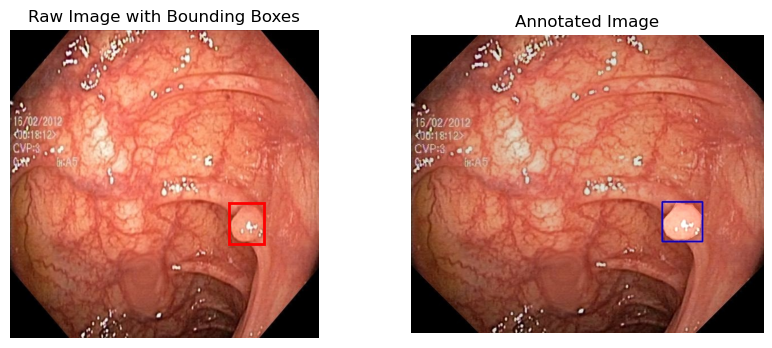

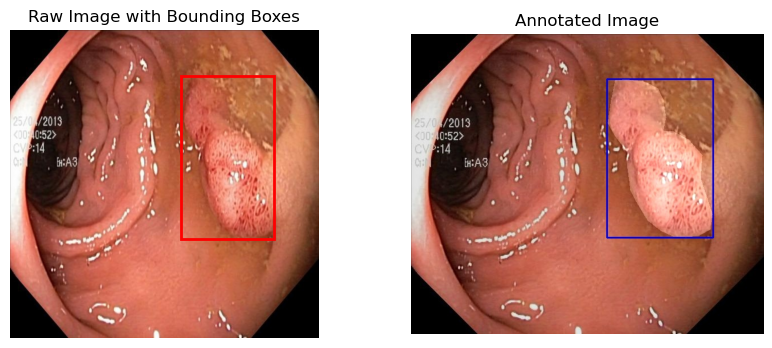

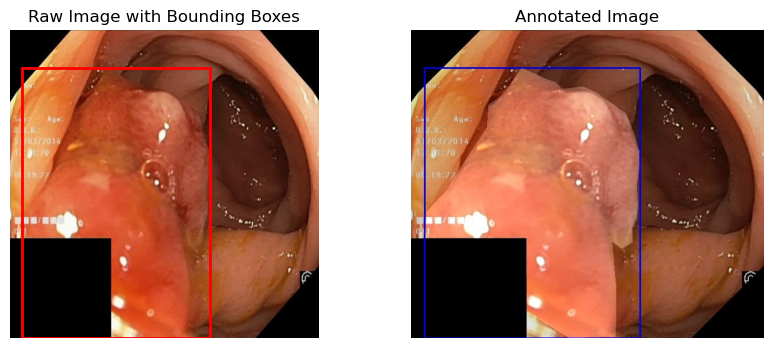

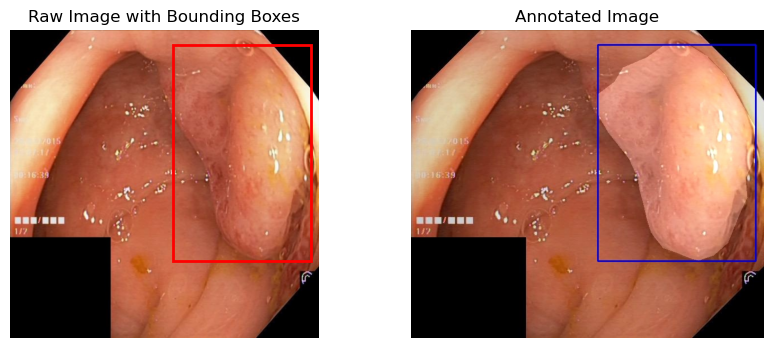

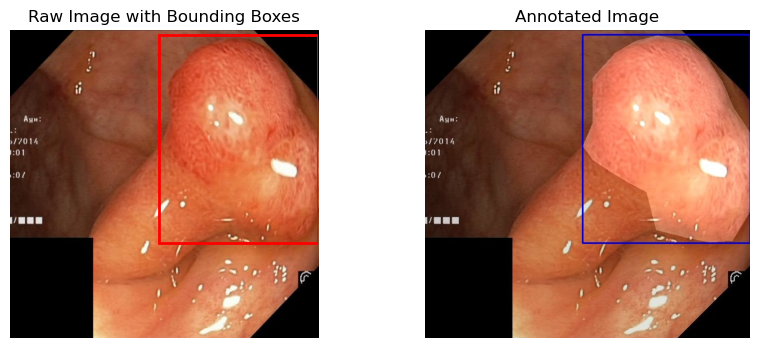

In [7]:
def plot_image_with_boxes(img, target, img_id):
    """
    Plots an image with bounding boxes.

    Args:
        img (Tensor): Image tensor of shape (3, H, W).
        target (dict): Target dictionary containing boxes and labels.        
        img_id (str): Image identifier.
    """
    img_with_boxes = os.path.join(PATH_ANNOTATED_IMAGES, img_id + ".jpg")
    img_with_boxes = Image.open(img_with_boxes).convert("RGB")
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    img = img.permute(1, 2, 0).numpy()  # Convert to (H, W, 3) for plotting
    ax[0].imshow(img)
    ax[0].axis('off')

    for box, label in zip(target['boxes'], target['labels']):
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)
        ax[0].set_title(f'Raw Image with Bounding Boxes')
        ax[1].imshow(img_with_boxes)

        ax[1].set_title(f'Annotated Image')
        ax[1].axis('off')

    plt.show()

for i in range(5):
  img, target, img_id = dataset_fasterrcnn[i+100]
  plot_image_with_boxes(img, target, img_id)

Now let's see if how potential images with multiple bounding boxes or no bounding boxes at all are handled.

In [8]:
total_boxes = 0
for _, target, _ in dataset_fasterrcnn:
    total_boxes += target["boxes"].shape[0]

print("Total bounding boxes:", total_boxes)

Total bounding boxes: 1071


Checking, if some images have multiple bounding boxes:

In [9]:
box_counts = []
for _, target, img_id in dataset_fasterrcnn:
    n_boxes = target["boxes"].shape[0]
    box_counts.append((img_id, n_boxes))
box_counts.sort(key=lambda x: x[1], reverse=True)
for img_id, n_boxes in box_counts[:5]:
    print(f"{img_id}: {n_boxes} bounding boxes")

cju3uhb79gcgr0871orbrbi3x: 10 bounding boxes
cju414lf2l1lt0801rl3hjllj: 4 bounding boxes
cju0roawvklrq0799vmjorwfv: 3 bounding boxes
cju32a52lb9rc0799xi40qs00: 3 bounding boxes
cju43c92lm5cj0755lorsorfg: 3 bounding boxes


Checking if the multiple bounding boxes are correctly plotted:

Visualizing: cju0roawvklrq0799vmjorwfv


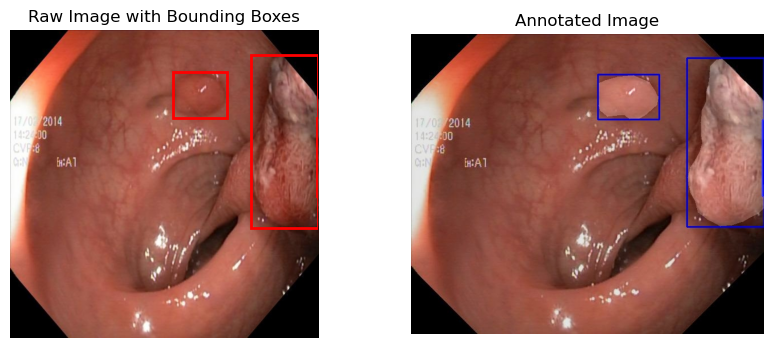

In [10]:
for img, target, img_id in dataset_fasterrcnn:
    if target["boxes"].shape[0] > 1:
        print("Visualizing:", img_id)

        plot_image_with_boxes(img, target, img_id)
        break

Checking if some images have no bounding box at all:

In [11]:
image_ids = {os.path.splitext(os.path.basename(path))[0] for path in image_paths}
labeled_ids = set(labels_df['id'].unique())
unlabeled_ids = image_ids - labeled_ids
len(unlabeled_ids)  # should be 0 if all images are labeled

0

## Batch Data Loaders

In order to load the images in batches, we define batch generating functions. Again one for YOLO format and one for Faster RCNN format.

For yolo, we have to implement the batch generating function by ourselves: 

In [21]:
def collate_fn_fasterrcnn(batch):
    return tuple(zip(*batch))

def collate_fn_yolo(batch):
    """
    Custom collate function for YOLO-format batches.
    
    Takes a list of (image, targets, img_id) tuples and combines them into:
        - images: stacked tensor of shape (B, 3, H, W)
        - all_targets: concatenated tensor of shape (M, 6) where each row is 
          [batch_index, class, x_center, y_center, width, height]
        - img_ids: list of image identifiers
    """
    images = []
    all_targets = []
    img_ids = []

    for i, (img, targets, img_id) in enumerate(batch):
        images.append(img)
        img_ids.append(img_id)

        if targets.numel() > 0:
            # add column with the index of the image in the batch
            batch_idx = torch.full(
                (targets.size(0), 1),
                i,
                dtype=targets.dtype
            )
            # [batch_idx, class, x_c, y_c, w, h]
            t = torch.cat([batch_idx, targets], dim=1)
            all_targets.append(t)

    images = torch.stack(images, dim=0)  # (B,3,H,W)

    if len(all_targets) > 0:
        all_targets = torch.cat(all_targets, dim=0)
    else:
        all_targets = torch.zeros((0, 6), dtype=torch.float32)

    return images, all_targets, img_ids

In [25]:
dataloader_fasterrcnn = DataLoader(
    dataset_fasterrcnn,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn_fasterrcnn
)

dataloader_yolo = DataLoader(
    dataset_yolo,
    batch_size=8,
    shuffle=True,
    num_workers=0,  
    collate_fn=collate_fn_yolo
)

# try to iterate one batch
for images, targets, img_ids in dataloader_yolo:
    print("Batch images shape:", images.shape)  # (B,3,H,W)
    print("Targets shape:", targets.shape)      # (M,6) -> [batch_idx, class, x_c, y_c, w, h]
    print("Example img_ids:", img_ids[:3])
    break

Batch images shape: torch.Size([8, 3, 640, 640])
Targets shape: torch.Size([9, 6])
Example img_ids: ['cju2ulk385h170799rlklxob0', 'ck2bxskgxxzfv08386xkqtqdy', 'cju2oi8sq0i2y0801mektzvw8']


## Standard Faster RCNN

### Training

In [15]:
model = fasterrcnn_resnet50_fpn(
    weights="DEFAULT"
)

# replace classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(
    in_features,
    2               # 0 background, 1 polyp
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\Niklas/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [02:53<00:00, 965kB/s]  


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.1
)

In [27]:
model.train()

num_epochs = 10

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for images, targets, _ in dataloader_fasterrcnn:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    lr_scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f}")


KeyboardInterrupt: 